# Imports And Setup

In [2]:
import pickle
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [3]:
# Data file names
batch1_name = "CIFAR_data/data_batch_1"
batch2_name = "CIFAR_data/data_batch_2"
batch3_name = "CIFAR_data/data_batch_3"
batch4_name = "CIFAR_data/data_batch_4"
batch5_name = "CIFAR_data/data_batch_5"
batchT_name = "CIFAR_data/test_batch"
meta_name = "CIFAR_data/batches.meta"

# Data Loading And Cleaning

In [4]:
# Used to load in the data files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
# Load in each data file
batch1 = unpickle(batch1_name)
batch2 = unpickle(batch2_name)
batch3 = unpickle(batch3_name)
batch4 = unpickle(batch4_name)
batch5 = unpickle(batch5_name)
batchT = unpickle(batchT_name)

In [6]:
# What does the data look like?
print(batch1.keys())             # Keys
print(batch1[b'batch_label'])    # Batch label
print(batch1[b'labels'][:10])    # Labels
print(type(batch1[b'labels']))   # Label type
print(batch1[b'data'][0])        # Data
print(type(batch1[b'data']))   # Data type
print(batch1[b'filenames'][:10]) # Filenames

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
b'training batch 1 of 5'
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]
<class 'list'>
[ 59  43  50 ... 140  84  72]
<class 'numpy.ndarray'>
[b'leptodactylus_pentadactylus_s_000004.png', b'camion_s_000148.png', b'tipper_truck_s_001250.png', b'american_elk_s_001521.png', b'station_wagon_s_000293.png', b'coupe_s_001735.png', b'cassowary_s_001300.png', b'cow_pony_s_001168.png', b'sea_boat_s_001584.png', b'tabby_s_001355.png']


In [7]:
# Store the labels and data as a numpy array
batch1['labels'] = np.array(batch1[b'labels'], dtype=np.int8)
batch1['data'] = batch1[b'data']
batch2['labels'] = np.array(batch2[b'labels'], dtype=np.int8)
batch2['data'] = batch2[b'data']
batch3['labels'] = np.array(batch3[b'labels'], dtype=np.int8)
batch3['data'] = batch3[b'data']
batch4['labels'] = np.array(batch4[b'labels'], dtype=np.int8)
batch4['data'] = batch4[b'data']
batch5['labels'] = np.array(batch5[b'labels'], dtype=np.int8)
batch5['data'] = batch5[b'data']
batchT['labels'] = np.array(batchT[b'labels'], dtype=np.int8)
batchT['data'] = batchT[b'data']

In [8]:
# Check if the conversion was successful
print(batch1['labels'][:10])
print(batch1['data'][0])

[6 9 9 4 1 1 2 7 8 3]
[ 59  43  50 ... 140  84  72]


In [9]:
# Load in the metadata
meta = unpickle(meta_name)

In [10]:
# Visualize the metadata
meta[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [11]:
# Convert the metadata to dictionaries
meta_numToLab = {i:str(meta[b'label_names'][i])[2:-1] for i in range(0, len(meta[b'label_names']))}
meta_labToNum = {str(meta[b'label_names'][i])[2:-1]:i for i in range(0, len(meta[b'label_names']))}

In [12]:
meta_numToLab

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [13]:
meta_labToNum

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [14]:
# Combine the data into a single array of labels and an array of data
# and store the data in a dnew dictionary
batchC = {"train":dict(), "test":dict(), "all":dict()}
batchC["train"]["y"] = np.concatenate((batch1["labels"], batch2["labels"], batch3["labels"], batch4["labels"], batch5["labels"]), dtype=np.int8)
batchC["train"]["X"] = np.concatenate((batch1["data"], batch2["data"], batch3["data"], batch4["data"], batch5["data"]), dtype=np.uint8)
batchC["test"]["y"] = np.array(batchT["labels"], dtype=np.int8)
batchC["test"]["X"] = np.array(batchT["data"], dtype=np.uint8)
batchC["all"]["X"] = np.concatenate((batchC["train"]["X"], batchC["test"]["X"]))
batchC["all"]["y"] = np.concatenate((batchC["train"]["y"], batchC["test"]["y"]))

In [15]:
# Ensure the conversion was successful
assert np.array_equal(batchC["train"]["y"][:10], batch1["labels"][:10])
assert np.array_equal(batchC["train"]["y"][-10:], batch5["labels"][-10:])
assert np.array_equal(batchC["train"]["X"][:10], batch1["data"][:10])
assert np.array_equal(batchC["train"]["X"][-10:], batch5["data"][-10:])

assert np.array_equal(batchC["test"]["y"][:10], batchT["labels"][:10])
assert np.array_equal(batchC["test"]["y"][-10:], batchT["labels"][-10:])
assert np.array_equal(batchC["test"]["X"][:10], batchT["data"][:10])
assert np.array_equal(batchC["test"]["X"][-10:], batchT["data"][-10:])

assert batchC["train"]["X"].shape[0] + batchC["test"]["X"].shape[0] == batchC["all"]["X"].shape[0]
assert batchC["train"]["y"].shape[0] + batchC["test"]["y"].shape[0] == batchC["all"]["y"].shape[0]

In [16]:
# The data shapes
print(f'Train Labels: {batchC["train"]["y"].shape}')
print(f'Train Data:   {batchC["train"]["X"].shape}')
print(f'Test Labels:  {batchC["test"]["y"].shape}')
print(f'Test Data:    {batchC["test"]["X"].shape}')
print(f'All Labels:   {batchC["all"]["y"].shape}')
print(f'All Data:     {batchC["all"]["X"].shape}')

Train Labels: (50000,)
Train Data:   (50000, 3072)
Test Labels:  (10000,)
Test Data:    (10000, 3072)
All Labels:   (60000,)
All Data:     (60000, 3072)


# Linear Regression

In [17]:
# Create the model
LR = sk.linear_model.LinearRegression()

In [18]:
# Load a pretrained model
LR = joblib.load("models/LR.pkl")

# Or fit the model
#LR.fit(batchC["train"]["X"], batchC["train"]["y"])

In [19]:
# Check the train and test accuracy
print(f'Train: {LR.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Test: {LR.score(batchC["test"]["X"], batchC["test"]["y"])}')

Train: 0.1502478112317177
Test: 0.026348067178683765


In [20]:
# Save the model
joblib.dump(LR, "models/LR.pkl") 

['models/LR.pkl']

### Notes
- This classifier seemed to give terrible predictions.
- The training is pretty quick due to the number of parameters being low.
- The model is very quick to make predictions on all the data.
- Since the model has very few parameters, it will underfit any data that isn't linear, but it will make a quick prediction and it will train quickly.

#### Pros:
- The model takes little time to train
- The model makes a quick prediction

#### Cons:
- The model has very low accuracy when making predictions
- The model looks to overfit on the training data since the test accuracy is really far from the train accuracy

# Random Forest Classifier

In [26]:
# Create the models
RFC1 = RandomForestClassifier(n_estimators=100)
RFC2 = RandomForestClassifier(n_estimators=200)
RFC3 = RandomForestClassifier(n_estimators=10)
RFC4 = RandomForestClassifier(n_estimators=2)

In [27]:
# Load pretrained models
#RFC1 = joblib.load("models/RFC1.pkl")
#RFC2 = joblib.load("models/RFC2.pkl")
#RFC3 = joblib.load("models/RFC3.pkl")
#RFC4 = joblib.load("models/RFC4.pkl")

# Fit the models
RFC1.fit(batchC["train"]["X"], batchC["train"]["y"])
RFC2.fit(batchC["train"]["X"], batchC["train"]["y"])
RFC3.fit(batchC["train"]["X"], batchC["train"]["y"])
RFC4.fit(batchC["train"]["X"], batchC["train"]["y"])

RandomForestClassifier()

In [74]:
# Check the train and test accuracy
print(f'Model 1 Train: {RFC1.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 1 Test: {RFC1.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 2 Train: {RFC2.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 2 Test: {RFC2.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 3 Train: {RFC3.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 3 Test: {RFC3.score(batchC["test"]["X"], batchC["test"]["y"])}')
print(f'Model 4 Train: {RFC4.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model 4 Test: {RFC4.score(batchC["test"]["X"], batchC["test"]["y"])}')

Model 1 Train: 1.0
Model 1 Test: 0.4632
Model 2 Train: 1.0
Model 2 Test: 0.4819
Model 3 Train: 0.9932
Model 3 Test: 0.3679
Model 4 Train: 0.71766
Model 4 Test: 0.2286


In [66]:
# Save the models
joblib.dump(RFC1, "models/RFC1.pkl") 
joblib.dump(RFC2, "models/RFC2.pkl") 
joblib.dump(RFC3, "models/RFC3.pkl") 
joblib.dump(RFC4, "models/RFC4.pkl") 

['models/RFC4.pkl']

### Notes
- This classifier seemed to severely overfit on the train set.
- To try to make the model not overfit as much, the number of estimators is reduced, but this also severely impacts the test accuracy.
- The training isn't instant, but it also doesn't take too long like Gradient Descent.
- To make all predictions on the data, it takes about a few seconds on my laptop, so the prediction time is pretty quick.


#### Pros:
- The train and test accuracy are relatively high compared to the previous methods
- The training time is reasonable
- The time to make a prediction is not instant, but still reasonable

#### Cons:
- The model severealy overfits to the training data

# OvR Classifier

In [21]:
# Create and fit the model
OvR = OneVsRestClassifier(SVC().fit(batchC["train"]["X"], batchC["train"]["y"]))

In [22]:
# Load pretrained model
#OvR = joblib.load("models/OvR.pkl")

# Or fit the model
OvR.fit(batchC["train"]["X"], batchC["train"]["y"])

OneVsRestClassifier(estimator=SVC())

In [23]:
# Check the train and test accuracy
print(f'Model Train: {OvR.score(batchC["train"]["X"], batchC["train"]["y"])}')
print(f'Model Test: {OvR.score(batchC["test"]["X"], batchC["test"]["y"])}')

Model Train: 0.84128
Model Test: 0.5562


In [24]:
# Save the model
joblib.dump(OvR, "models/OvR.pkl")

['models/OvR.pkl']

### Notes
- This classifier performed pretty well on the train set, but not very well on the test set
- The model is clearly overfitting
- Compared to the other models, this one did pretty good on both sets
- The model takes hours to train while Gradient Descent took under an hour to train with 1000 steps and the other models took a few minuites to train.
- The model takes hours to make predictions for the test set while K Nearest Neighbors takes a under 30 minuites to make all predictions for the test set and all other models take at most a few minuites to predict the test set.

#### Pros:
- The model has a high train accuracy compared to the other models
- The model has an ok test accuracy compared to other models

#### Cons:
- The model takes forever to train
- The model takes forever to make a prediction
- The model is clearly overfitting to the train set

### Mean Squared Error

In [28]:
from sklearn.metrics import mean_squared_error
predictions = LR.predict(batchC["train"]["X"])
lin_mse = mean_squared_error(batchC["train"]["y"], predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

2.647726488393076

### Confusion Matrix

In [29]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(RFC1, batchC["train"]["X"], batchC["train"]["y"], cv=3)

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(batchC["train"]["y"], y_train_pred)

array([[2650,  260,  256,  112,  151,  120,  117,  184,  824,  326],
       [ 160, 2661,   67,  185,  124,  151,  199,  183,  317,  953],
       [ 530,  187, 1516,  350,  805,  340,  624,  318,  179,  151],
       [ 226,  236,  401, 1356,  408,  917,  701,  302,  133,  320],
       [ 304,  125,  675,  272, 1931,  288,  704,  397,  153,  151],
       [ 164,  202,  449,  806,  420, 1829,  457,  362,  109,  202],
       [  92,  203,  390,  390,  635,  332, 2626,  149,   45,  138],
       [ 209,  210,  253,  301,  566,  403,  263, 2276,  104,  415],
       [ 489,  432,   99,  160,  104,  190,   65,   84, 2945,  432],
       [ 198,  882,   73,  157,   89,  125,  156,  206,  350, 2764]])

### ROC Curve

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(batchC["train"]["y"], y_train_pred, pos_label=1)

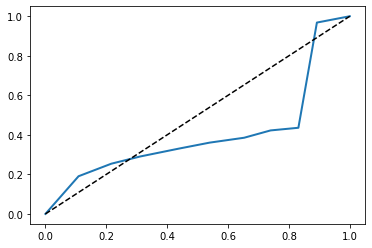

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()


### GridSearchVC

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#param_grid = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(batchC["train"]["X"], batchC["train"]["y"])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [35]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [38]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), params)

3.0880425299316503 {'max_features': 2, 'n_estimators': 3}
2.770810639506063 {'max_features': 2, 'n_estimators': 10}
2.676471835997698 {'max_features': 2, 'n_estimators': 30}
3.0691710788274924 {'max_features': 4, 'n_estimators': 3}
2.7623786851190406 {'max_features': 4, 'n_estimators': 10}
2.6557094302234527 {'max_features': 4, 'n_estimators': 30}
3.0559581148962103 {'max_features': 6, 'n_estimators': 3}
2.7499055983796974 {'max_features': 6, 'n_estimators': 10}
2.6481655159751627 {'max_features': 6, 'n_estimators': 30}
3.049069803508386 {'max_features': 8, 'n_estimators': 3}
2.7457468929236724 {'max_features': 8, 'n_estimators': 10}
2.6460353697140517 {'max_features': 8, 'n_estimators': 30}
3.0606901908629114 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2.7376471649940575 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.0361909616418323 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
2.734701592495971 {'bootstrap': False, 'max_features': 3, 'n_est